In [28]:
import xarray as xr 
import cartopy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cv2   
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
import os 
from matplotlib.patches import Polygon, FancyArrowPatch    # 用于画箭头的 ， 虽然没用到
from shapely.geometry import Polygon as ShapelyPolygon     # 用于确定多边形中心点位置
# 防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [29]:
"""
# 考虑了：
#     使用了轮廓，而非boxes
#     亮温: Tb < 241K, 且有 Tb<225K  , 识别的是 241K  
#     面积: 大于4e4 km^2
#     覆盖率计算：   如果前一个时刻有n个轮廓与当前时刻的轮廓重叠率超两者较小的那个的整体面积的50%，
#                  则挑选出前一时刻具有较大面积的那个
#      椭圆画在了cv2.ellipse上
#

# 注意：
#      对单个时间的没有做融合整合， 因为取出的是外轮廓, 后面可以考虑融合
#      前后时刻的split和merge还需要再考虑

"""

'\n# 考虑了：\n#     使用了轮廓，而非boxes\n#     亮温: Tb < 241K, 且有 Tb<225K  , 识别的是 241K  \n#     面积: 大于4e4 km^2\n#     覆盖率计算：   如果前一个时刻有n个轮廓与当前时刻的轮廓重叠率超两者较小的那个的整体面积的50%，\n#                  则挑选出前一时刻具有较大面积的那个\n#      椭圆画在了cv2.ellipse上\n#\n\n# 注意：\n#      对单个时间的没有做融合整合， 因为取出的是外轮廓, 后面可以考虑融合\n#      前后时刻的split和merge还需要再考虑\n\n'

In [30]:
""" 
获取的数据：
    亮温： tbdata 
    经度： lon 
    纬度： lat 
"""
dir_pth = r"./data/"
all_datafiles_pth_list = os.listdir(dir_pth)
init_data_list  = []
tb_data_list = []
for i_file_pth in all_datafiles_pth_list:
    print(dir_pth+i_file_pth)
    i_file_data = xr.open_dataset(dir_pth+i_file_pth)
    # 处理单个文件数据   
    # i_file_data  =  i_file_data.sel(lat = slice(-10, 30), lon = slice(90, 180)  )  
    i_file_data  =  i_file_data.sel(lat = slice(-60, 60), lon = slice(-180, 180)  )  

    tbdata = i_file_data.irwin_cdr[0].to_numpy()   # 由于获取的数据是（1，lon, lat) 所有需转换成（lon, lat)， 且为numpy格式

    # 保存的数据
    init_data_list.append(i_file_data)    
    tb_data_list.append(tbdata)

lon = i_file_data.lon    # 每个文件的lon, lat 都一样，此处取第一个文件的lon, lat
lat = i_file_data.lat   


./data/GRIDSAT-B1.2023.07.23.03.v02r01.nc
./data/GRIDSAT-B1.2023.07.23.06.v02r01.nc
./data/GRIDSAT-B1.2023.07.23.09.v02r01.nc


In [31]:
print(i_file_data.irwin_cdr)

<xarray.DataArray 'irwin_cdr' (time: 1, lat: 1715, lon: 5143)>
[8820245 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -59.99 -59.92 -59.85 -59.78 ... 59.85 59.92 59.99
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * time     (time) datetime64[ns] 2023-07-23T09:00:00
Attributes:
    long_name:          NOAA FCDR of Brightness Temperature near 11 microns (...
    standard_name:      toa_brightness_temperature
    units:              Kelvin
    comment:            Nadir-most observations
    valid_range:        [140. 375.]
    Note_A:             Calibration correction of Kanpp (2007) not applied
    Note_B:             The IRWIN_CDR data have been View Zenith corrected us...
    intergeo_cal_flag:  0


# 连续区域识别 

## 找出需要的亮温区对应轮廓

In [32]:
# 找边界
def get_outline_contour(tb): 
    """
    tb: 亮温数据，  二维numpy数组
    return: 

    """
    # 找出所有Tb < 225K的像素
    _, cold_cores = cv2.threshold(tb, 225, 255, cv2.THRESH_BINARY_INV)
    cold_cores = cold_cores.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理
    
    # 找出所有Tb < 241K的像素
    _, cold_regions = cv2.threshold(tb, 241, 255, cv2.THRESH_BINARY_INV)
    cold_regions = cold_regions.astype(np.uint8)
    
    # # 使用形态学膨胀操作扩展冷云区域、冷云核心，   也就是把边缘弄得精细一些。   
    # kernel = np.ones((1,1), np.uint8)  
    # cold_cores = cv2.dilate(cold_cores, kernel, iterations= 1)
    # cold_regions = cv2.dilate(cold_regions, kernel, iterations= 1)

    #按照 冷区 获取轮廓
    contours_cold_cores, _ = cv2.findContours(cold_cores, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_cold_regions, _ = cv2.findContours(cold_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 准备一个掩膜用于保存需要保留的cold_regions轮廓
    all_cnts = []
    Tb_mask = np.zeros_like(cold_regions)
    for region_contour in contours_cold_regions:
        for core_contour in contours_cold_cores:
            # 检查cold_cores的轮廓是否在cold_regions的轮廓内部    ， # core_contour[0][0]是np array, 不是list
            dist = cv2.pointPolygonTest(region_contour, tuple(core_contour[0][0].tolist()), measureDist=False)
            if dist >= 0:  # 如果core_contour的一个点在region_contour内（包括边界）
                # 绘制这个cold_regions轮廓到掩膜上
                cv2.drawContours(Tb_mask, [region_contour], -1, color=255, thickness=cv2.FILLED)

                # 保存轮廓点list
                all_cnts.append(region_contour)
                # 保存单独轮廓
                # single_mask = np.zeros_like(cold_regions)
                # cv2.drawContours(single_mask, [region_contour], -1, color=255, thickness=cv2.FILLED)
                # single_mask=  single_mask.astype(bool)
                # single_mask &= (tb< 241)
                # individual_masks.append(single_mask)
                break  # 一旦找到匹配，跳出循环检查下一个cold_regions轮廓
    tbcondition = ((Tb_mask==255) & (tb < 241))
    Tb_mask = np.where(tbcondition, Tb_mask, 0)
    return Tb_mask , all_cnts

In [33]:
_, cold_cores = cv2.threshold(tb_data_list[0], 225, 255, cv2.THRESH_BINARY_INV)
cold_cores = cold_cores.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理

# 找出所有Tb < 241K的像素
_, cold_regions = cv2.threshold(tb_data_list[0], 241, 255, cv2.THRESH_BINARY_INV)
cold_regions = cold_regions.astype(np.uint8)


#====================================画轮廓=============================================
#按照 冷区 获取轮廓
contours_cold_cores, _ = cv2.findContours(cold_cores, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_cold_regions, _ = cv2.findContours(cold_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
drawing = np.full((tb_data_list[0].shape[0], tb_data_list[0].shape[1], 3), 255, dtype=np.uint8)

# 获取轮廓掩码
cv2.drawContours(drawing, contours_cold_regions, -1, (0, 0, 255), thickness = 2) # 使用绿色 (B,G,R)=(0,255,0) 来绘制 cold regions
cv2.drawContours(drawing, contours_cold_cores, -1, (255, 0, 0), thickness= cv2.FILLED) # 使用红色 (B,G,R)=(255,0,0) 来绘制 cold cores

flip_drawing = cv2.flip(drawing, 0)
# 显示结果图像
# cv2.imshow('Contours', flip_drawing)
# 保存图片
cv2.imwrite('./img/00_init_Tbdata.png', flip_drawing)
cv2.waitKey(0)
cv2.destroyAllWindows()


## 判断面积


In [34]:
def judge_area(judge_tb_mask, all_cnts, real_area_threshold=4e4):
    jg_pixel_threshold = real_area_threshold / (8 * 8)   # 1 pixel = 8*8 km^2 
    contours_pts_list = [] 
    judge_area_mask = np.zeros_like(judge_tb_mask, dtype=np.uint8)
    for cnt in all_cnts:
        i_cnt_mask = np.zeros_like(judge_tb_mask, dtype=np.uint8)
        cv2.drawContours(i_cnt_mask, [cnt], -1, color=255, thickness=cv2.FILLED)
        # 判断面积 
        conditon = np.logical_and(judge_tb_mask, i_cnt_mask).astype(np.uint8)
        area = cv2.countNonZero(conditon)
        if area > jg_pixel_threshold:
            contours_pts_list.append(cnt)
            cv2.drawContours(judge_area_mask, [cnt], -1, color=255, thickness=cv2.FILLED)
    return  judge_area_mask, contours_pts_list,

In [35]:
""" 下方函数未使用 """
# def refine_contours(tb, judge_tb_mask, all_cnts):
#     refined_mask = np.zeros_like(judge_tb_mask, dtype=np.uint8)
#     refined_cnts = []

#     for cnt in all_cnts:
#         # Step 1: 创建当前轮廓的mask
#         cnt_mask = np.zeros_like(tb, dtype=np.uint8)
#         cv2.drawContours(cnt_mask, [cnt], -1, color=255, thickness=cv2.FILLED)

#         # Step 2: 获取当前轮廓内的像素坐标 (y, x)
#         pts = np.column_stack(np.where(cnt_mask > 0))

#         # Step 3: 检查这些点是否满足 tb[y, x] < 241
#         valid_pts = []
#         for y, x in pts:
#             if tb[y, x] < 241:
#                 valid_pts.append([x, y])  # OpenCV 使用 (x, y) 格式保存点

#         # Step 4: 如果有效点太少，跳过该轮廓， 其实找面积的时候已经保证了点的数量。 
#         if len(valid_pts) < 3:
#             continue

#         # Step 5: 将有效点转为 NumPy 数组
#         valid_pts = np.array(valid_pts, dtype=np.int32)
#         # Step 7: 更新新的mask和轮廓列表 
#         contour = valid_pts.reshape((-1, 1, 2))  # 新排序这些点，使其形成一个闭合轮廓（按原顺序即可）
#                                              # 注意：OpenCV 的 drawContours 要求输入的点是一个 shape 为 (n, 1, 2) 的数组， 所以我们 reshape 成 (n, 1, 2)
#         cv2.drawContours(refined_mask, [contour], -1, 255, thickness=cv2.FILLED)
#         refined_cnts.append(contour)
#         # 构建新多边形/轮廓 ==> 使用函数cv2.convexHull构建
#         # # valid_pts = np.array(valid_pts, dtype=np.int32)
#         # # hull = cv2.convexHull(valid_pts)  # 或者使用 approxPolyDP 简化形状
        
#     return refined_mask, refined_cnts


' 下方函数未使用 '

## 椭圆

In [36]:
# 拟合长轴
def judge_ellipse(otline_pts_list):
    mch_elip_area_list  = []
    count_unfit_elip = 0
    for cnt in otline_pts_list:
        if len(cnt) >= 5: # 确保有足够数量的点来拟合椭圆
            ellipse = cv2.fitEllipse(cnt)

            # 判断主长轴、离心率
            major_axis_legth = max(ellipse[1][0], ellipse[1][1])
            minor_axis_legth = min(ellipse[1][0], ellipse[1][1])
            # 离心率计算
            ecc = np.sqrt(1 - (minor_axis_legth / major_axis_legth)**2)
            if (major_axis_legth > (100/8)) or (ecc > 0.4):    # 1 pixel = 8km
                mch_elip_area_list.append(cnt)
        else:
            count_unfit_elip += 1
            print("统计无法拟合椭圆的轮廓数：", count_unfit_elip)
    return  mch_elip_area_list


## 轮廓点转换为经纬度(待使用)

In [37]:
def outline2lonlat(otline_pts_list, lon , lat ):
    lonlat_pts_list = []
    for i_outline in otline_pts_list:
        # print(i_outline.squeeze().shape)
        # print("print(print(i_outline.squeeze()))")
        # print(print(i_outline.squeeze()))
        # print("==================================")
        
        i_new_list = []
        for i_lonlat in i_outline.squeeze():   #  [x  y] 的一个点  
            i_lon = lon[i_lonlat[0]].item()
            i_lat = lat[i_lonlat[1]].item()
            i_new_list.append([i_lon, i_lat]) 
        lonlat_pts_list.append(i_new_list)
    return lonlat_pts_list

## 将轮廓点转化为对应的掩码和真实数据

In [38]:
def get_dataAndmask(outline_mask, matched_outline_list, initdata):
    result_mask = np.zeros_like(outline_mask)   
    for i_outline_3Dpts in matched_outline_list:
        cv2.drawContours(result_mask, [i_outline_3Dpts], -1, color=255, thickness=cv2.FILLED)
    data = np.where(result_mask, initdata, np.nan  )  # result_mask中的元素为0或者255，0也就是False, 所以mask可以作为掩码
    return  data , result_mask 

## 云的移动追踪

In [39]:
def calculate_overlap(contour1, contour2, tb):
    """
    计算两个轮廓之间的重叠比例（intersection / area of contour1），仅考虑tb<241的区域。
    :param contour1: 轮廓1, 表示以前时刻
    :param contour2: 轮廓2， 表示当前时刻
    :param tb: 输入的真实数据数组
    :return: overlap ratio
    """
    mask1 = np.zeros(tb.shape, dtype=np.uint8)
    mask2 = np.zeros(tb.shape, dtype=np.uint8)
    
    # 绘制轮廓到掩膜上
    cv2.drawContours(mask1, [contour1], -1, color=1, thickness=cv2.FILLED)
    cv2.drawContours(mask2, [contour2], -1, color=1, thickness=cv2.FILLED)

    # 将不满足tb < 241的区域从掩膜中排除
    mask1 &= (tb < 241)
    mask2 &= (tb < 241)

    # 计算交集和各自的面积
    intersection = np.logical_and(mask1, mask2).sum()
    area1 = mask1.sum()  # 因为mask1是二值化的，可以直接用sum来计算面积
    area2 = mask2.sum()

    if min(area1, area2) > 0:
        ratio = intersection / min(area1, area2)
    else:
        ratio = 0  # 避免除以0的情况
    # ratio = denominator = np.minimum(area1, area2)
    return ratio , area1 

In [40]:
"""   考虑前一时刻最大面积的追踪 函数"""
def track_clouds(contours_list, tb_datalist):
    """
    :param contours_list: list[list[contours]]，每个元素是一帧中的多个轮廓
    :return: tracked_contours: 每个轮廓带有一个ID
    """
    tracked_contours = []  # 存储每帧的 (contour, id) 列表
    current_id = 0

    for i, frame_contours in enumerate(contours_list):
        current_tracked = []

        if i == 0:
            # 第一帧：所有轮廓都是新ID
            for cnt in frame_contours:
                current_tracked.append((cnt, current_id))
                current_id += 1

        else:
            prev_tracked = tracked_contours[i - 1]
            used_idx = set()  # 已匹配的前一帧轮廓索引

            for cnt in frame_contours:
                candidates = []  # 存储所有满足 overlap_ratio ≥ 0.5 的匹配项

                for j, (prev_cnt, pid) in enumerate(prev_tracked):
                    if j in used_idx:
                        continue

                    # 调用你自己的 calculate_overlap
                    overlap_ratio, area1 = calculate_overlap(prev_cnt, cnt, tb_datalist[i])

                    if overlap_ratio >= 0.5:
                        # 同时保存 j（索引）、pid（ID）、area1（前一帧轮廓的有效面积）
                        candidates.append((j, pid, area1))

                if candidates:
                    # 按面积从大到小排序，取最大面积的那个
                    best_j, best_pid, _ = sorted(candidates, key=lambda x: x[2], reverse=True)[0]
                    used_idx.add(best_j)
                    current_tracked.append((cnt, best_pid))
                else:
                    # 没有匹配项 → 新云团
                    current_tracked.append((cnt, current_id))
                    current_id += 1

        tracked_contours.append(current_tracked)

    return tracked_contours

# 原始文件数据处理与函数调用

In [41]:
# 获取不同时刻的完整轮廓
contours_list = []  # 存储每个时刻的轮廓列表
for tb in tb_data_list:
    outline_mask ,all_cnts = get_outline_contour(tb)  # 和 tb单个文件的shape 一样
    judge_area_mask, contours_pts_list = judge_area(outline_mask, all_cnts)
    mch_area_elip_list   = judge_ellipse(contours_pts_list)
    contours_list.append(contours_pts_list)


In [42]:
# 开始追踪
tracked_contours  =  track_clouds(contours_list, tb_data_list) 


In [43]:
"""  挑选出同一个ID的时刻数 ≥2 个时刻的云团"""
# 第一步：按ID分组，并记录每个ID在哪些时间帧中出现过  
id_dict = {}
for t, frame in enumerate(tracked_contours):
    for contour, cid in frame:
        if cid not in id_dict:
            id_dict[cid] = []  # 初始化该ID的列表
        id_dict[cid].append({
            't': t,
            'contour': contour
        })

# 第二步：筛选出存在 ≥2 个时刻的云团，并以 {cid: {t: contour}} 的形式保存

t_dict = {}
for id in id_dict.keys():
    items = id_dict[id]
    if len(items) >= 2:
        for item in items:
            t = item['t']
            cnt = item['contour']
            if t not in t_dict:
                t_dict[t] = []
            t_dict[t].append({
                'id': id,
                'contour': cnt
            })

In [44]:
track_otlin_list = []
clean_otline_data = []
for i_t in t_dict.keys():
    i_t_track_otlin_list = []
    for i in range(len(t_dict[i_t])):
        cnt = t_dict[i_t][i]['contour']
        i_t_track_otlin_list.append(cnt)
    data , result_mask = get_dataAndmask(outline_mask, i_t_track_otlin_list, tb_data_list[i_t])
    data = np.where(data < 241, data, np.nan)
    # 保存数据
    clean_otline_data.append(data)
    track_otlin_list.append(i_t_track_otlin_list)


# 开始画图

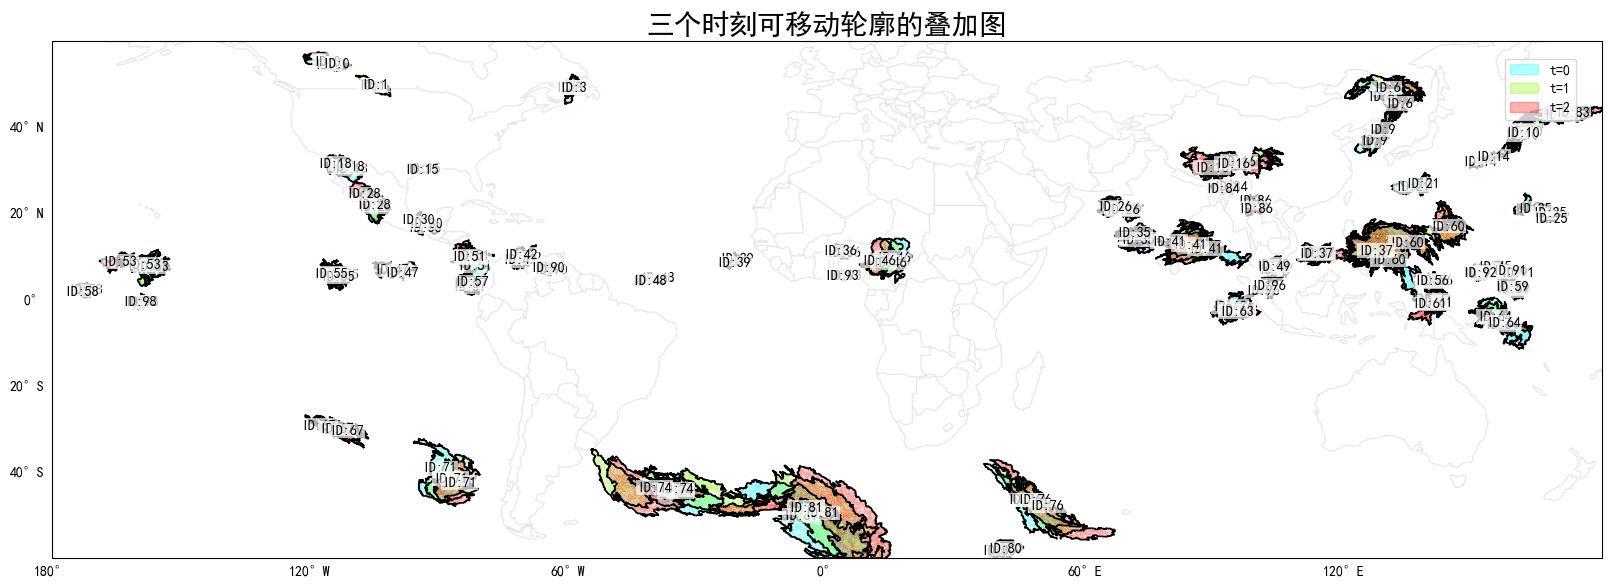

In [55]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch 

# 假设已经有了：
# tracked_contours: track_clouds 返回的结果
# tb_data_list: 所有亮温数据 (list of 2D arrays)
# lon, lat: 经纬度网格数组
# clean_otline_data: 每帧中筛选后的有效数据（用于颜色填充）
# t_dict: 后处理后得到的数据结构，包含 {t: [{'id': id, 'contour': contour}, ...]}

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True, linewidth=0)
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
# ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())

cmaplist = ['Blues', 'Reds', 'binary']
# colors = ['#FF4500', '#32CD32', '#007BFF']  # Orange, Green, Blue
colors = ['aqua', 'lawngreen', 'red']

for i_t in range(len(clean_otline_data)):
# for i_t in range(1,2):
    # 绘制背景数据（可选）
    data = clean_otline_data[i_t]
    single_color_cmap = ListedColormap([colors[i_t]])
    cs = ax.contourf(lon, lat, data, 
                     cmap=single_color_cmap,
                     # cmap=cmaplist[i_t],
                     alpha=0.2,
                     transform=ccrs.PlateCarree())

    for item in t_dict[i_t]:
        cid = item['id']
        cnt = item['contour']

        # 轮廓点坐标是 OpenCV 格式：[[[x1,y1]], [[x2,y2]], ...] → 提取为 (x, y)
        x_list = [pt[0][0] for pt in cnt]
        y_list = [pt[0][1] for pt in cnt]

        for i in range(len(x_list)):
            x_list[i] = lon[x_list[i]].item()
        for i in range(len(y_list)):
            y_list[i] = lat[y_list[i]].item()

        cx = np.mean(x_list)  # 轮廓中心横坐标
        cy = np.mean(y_list)

        # 在图上绘制轮廓线
        ax.plot(x_list, y_list, color='black', linewidth=1.2, transform=ccrs.PlateCarree())

        # 在轮廓中心绘制文本标签
        ax.text(cx, cy, f'ID:{cid}', fontsize=10, color='black',
                ha='center', va='center', weight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
                transform=ccrs.PlateCarree())
    
    legend_elements = []
    labels = ['t=0', 't=1', 't=2'] # 根据实际情况修改时间描述

    for color, label in zip(colors, labels):
        legend_elements.append(Patch(facecolor=color, 
                                     edgecolor=color, 
                                     alpha=0.3, # 这里设置为与contourf相同的alpha值
                                     label=label))
    
    # 添加图例到图表
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.933, 0.98), loc='upper left')

# 添加标题
ax.set_title('三个时刻可移动轮廓的叠加图', fontsize=20)

# 保存图片
plt.savefig('./img/02_叠加图.png', bbox_inches='tight')
plt.show()


In [56]:
from matplotlib.colors import Normalize 
def tackSubImg(
        init_tb_data_list,
        clean_data,
        lon, 
        lat , 
        savepth,
        dpi = 300,
        ):
    """
    clean_data: list, 每个元素代表一个时刻的二维底图数据， 
    tracked_boxesPoints_list: list, 每个元素包含一个时刻的框的信息
    savepth: 画出的图的保存路径
    若想调整画图范围， 则修改 i_ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    """
    fig, ax = plt.subplots(2, 3, figsize=(9, 4), subplot_kw={'projection': ccrs.PlateCarree()},)
    global_min = min([data.min() for data in init_tb_data_list + clean_data])
    global_max = max([data.max() for data in init_tb_data_list + clean_data])
    
    norm = Normalize(vmin=global_min, vmax=global_max)
    # 添加网格和底图元素
    for i_row in range(ax.shape[0]):
        for i_col in range(ax.shape[1]):
            # 添加经纬度网格线并显示标签
            i_ax = ax[i_row, i_col]
            grid = i_ax.gridlines(draw_labels=True, linewidth=0)
            grid.top_labels = False
            grid.right_labels = False 
            if i_col == 0 :
                grid.left_labels = True
            else:
                grid.left_labels = False
    
            i_ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
            i_ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
            # i_ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    
    

    contourf_instance = None
    extend = 'neither'  # 使用默认值
    my_cmap = 'jet'
    for i_t in range(len(init_tb_data_list)):
        for i in range(2):   # 两组图，一组为原图，一组为识别出来的图
            if i == 0:   # 原图
                # 取出 数据小于241的数据
                init_tb_data = np.where(init_tb_data_list[i_t] < 241, init_tb_data_list[i_t], np.nan)
                contourf_plot = ax[i, i_t].contourf(lon, lat, init_tb_data,
                                                    cmap=my_cmap,
                                                    vmin=global_min,
                                                    vmax=global_max,
                                                    extend = extend,
                                                    transform=ccrs.PlateCarree())
                ax[i, i_t].set_title(f't={i_t}')
                
                if contourf_instance is None:
                    contourf_instance = contourf_plot
            
            else:  # 筛过数据的图 
                ax[i, i_t].contourf(lon, lat,   
                                    clean_data[i_t],
                                    cmap=my_cmap,
                                    vmin=global_min,
                                    vmax=global_max,
                                    extend = extend,
                                    transform=ccrs.PlateCarree())

    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])  # [left, bottom, width, height]
    cbar = fig.colorbar(contourf_instance, cax=cbar_ax, orientation='vertical', extend = extend)
    cbar.set_label('单位: K', fontsize=10)
    # 保存
    plt.savefig(savepth, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [47]:
print("查看数据范围:")
a= np.concatenate(clean_otline_data)
b = np.concatenate(tb_data_list)
print("已经清理过的数据有：")
print(np.nanmin(a))
print(np.nanmax(a))

print("已经处理的数据有：")
print(np.nanmin(np.where(b<241, b, np.nan)))
print(np.nanmax(np.where(b<241, b, np.nan)))

查看数据范围:
已经清理过的数据有：
182.89
240.98999
已经处理的数据有：
182.89
240.98999


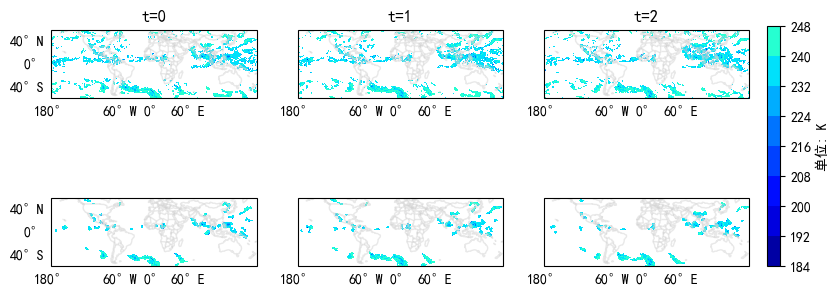

In [58]:
# 画图 
savepth = r'D:\00my_Github_Resp\02Atmos_graduate\MCS_recognition\img\03_分开图.png'
tackSubImg(tb_data_list,
           clean_otline_data,
           lon, 
           lat, 
           savepth,)


# 将椭圆画在图上

In [60]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch 
import matplotlib.patches as mpatches
from PIL import Image,ImageDraw,ImageFont

# 假设已经有了：
# tracked_contours: track_clouds 返回的结果
# tb_data_list: 所有亮温数据 (list of 2D arrays)
# lon, lat: 经纬度网格数组
# clean_otline_data: 每帧中筛选后的有效数据（用于颜色填充）
# t_dict: 后处理后得到的数据结构，包含 {t: [{'id': id, 'contour': contour}, ...]}


# 画椭圆
for i_t in range(len(track_otlin_list)):
    # data = clean_otline_data[i_t]
    w = tb_data_list[0].shape[0]
    h = tb_data_list[0].shape[1]
    i_t_cnts = track_otlin_list[i_t]
    i_t_cnts_mask = np.full((w,h,3),255, dtype=np.uint8)
    i_t_ellipse_mask = np.full((w,h,3) ,255, dtype=np.uint8)

    for i_cnt in i_t_cnts:
        if len(i_cnt) >= 5:  # 确保有足够的点来拟合椭圆
            ellipse = cv2.fitEllipse(i_cnt)
            # 画椭圆
            
            cv2.ellipse(i_t_ellipse_mask, ellipse, color=(0, 0, 255), thickness=2)
            # 画出底图
            cv2.drawContours(i_t_cnts_mask, [i_cnt], -1, color=(255, 0,0), thickness=2)
            i_t_flip_cnts_mask = cv2.flip(i_t_cnts_mask, 0)
            i_t_flip_ellipse_mask = cv2.flip(i_t_ellipse_mask, 0)
            # conbined_mask = cv2.add(i_t_flip_ellipse_mask, i_t_flip_cnts_mask)
            conbined_mask = cv2.addWeighted(i_t_flip_ellipse_mask, 0.5, i_t_flip_cnts_mask, 0.5, 0)
    pil_image = Image.fromarray(cv2.cvtColor(conbined_mask, cv2.COLOR_BGR2RGB))

    # font = ImageFont.load_default()
    # title = f"t{i_t}"  # 根据文件名生成标题
    # draw = ImageDraw.Draw(pil_image)
    # text_bbox = draw.textbbox((0, 0), title, font=font)
    # text_width = text_bbox[2] - text_bbox[0]
    # text_height = text_bbox[3] - text_bbox[1]
    # position = ((pil_image.width - text_width) / 2, 10)  # 在图像顶部中央添加标题
    
    # # 添加标题到图像
    # draw.text(position, title, (0, 0, 0), font=font)  # 文字颜色为黑色
    
    # 显示/保存结果
    dpi = (300, 300)  # 分辨率设置为 300 dpi
    output_filename = f"./img/01_img_t_{i_t}_椭圆示例图.png"
    pil_image.save(output_filename, dpi=dpi)
    # 弹框画图
    cv2.imshow(f"img{i_t}", conbined_mask)  
    cv2.waitKey(0)
cv2.destroyAllWindows()

        #    # 图像坐标转换为经纬度
        #     center_lon , center_lat = lon[int(center[0])].item(), lat[int(center[1])].item() 
            
        #    # 椭圆宽度、高度， 即长轴和短轴短轴的长度
        #     width ,  height = max(axes)*8 , min(axes)*8/  # 1pixel = 8km , width, height对应长轴和短轴的长度
        #     # width ,  height = max(axes) , min(axes)  # 1pixel = 8km , width, height对应长轴和短轴的长度
        #     # width , height = max(axes)/scale_factor , min(axes)/scale_factor

        #    # angle在opencv中为顺时针旋转的角度，需要转换为逆时针旋转的角度， 因为matplotlib要求的是逆时针旋转 
        #     real_angle = -angle 
        #     #画图
            # ax.add_patch(mpatches.Ellipse(xy = (center_lon, center_lat), 
            #                         width = width, 
            #                         height = height, 
            #                         angle = real_angle, 
            #                         fill = False, 
            #                         edgecolor = colors[i_t], 
            #                         linewidth = 2
            #                         ))


In [51]:
# import matplotlib.patches as mpatches
# for i_t in range(len(track_otlin_list)):
#     i_t_cnts = track_otlin_list[i_t]
#     i_t_cnts_mask = np.zeros(tb_data_list[0].shape, dtype=np.uint8)
#     for i_cnt in i_t_cnts:
#         if len(cnt) >= 5:  # 确保有足够的点来拟合椭圆
            
#             center, axes, angle = cv2.fitEllipse(cnt)
            
#            # 图像坐标转换为经纬度
#             center_lon , center_lat = lon[int(center[0])].item(), lat[int(center[1])].item()
#            # 椭圆宽度、高度， 即长轴和短轴短轴的长度
#             width ,  height = max(axes)*8 , min(axes)*8  # 1pixel = 8km , width, height对应长轴和短轴的长度
#            # angle在opencv中为顺时针旋转的角度，需要转换为逆时针旋转的角度， 因为matplotlib要求的是逆时针旋转 
#             real_angle = -angle 
#             #画图
#             ax.add_patch(mpatches.Ellipse(xy = (center_lon, center_lat), 
#                                     width = width, 
#                                     height = height, 
#                                     angle = real_angle, 
#                                     fill = False, 
#                                     edgecolor = 'r', 
#                                     linewidth = 2
#                                     ))
